In [2]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pachner_traversal.utils import compute_rhat, data_path, set_style

set_style()

In [3]:
mcmc_result_path = data_path / "results" / "mcmc" / "generic_samples" / "20251004_1845"
assert mcmc_result_path.exists()

In [4]:
tet_map = {
    l: i for i, l in enumerate("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
}

In [5]:
metrics = [
    "agg_score_alex_norm",
    "agg_score_alex_deg",
    "agg_score_alex_det",
    "agg_score_edge_var",
    "agg_score_num_gen",
]

for metric in metrics:
    df = pd.read_csv(mcmc_result_path / f"{metric}_chains.csv", index_col=0)
    rhat, ess = compute_rhat(df)
    print(f"{metric:20} & {rhat:.3f} & {ess:,.0f} \\\\")

agg_score_alex_norm  & 1.003 & 69,540 \\
agg_score_alex_deg   & 1.004 & 69,500 \\
agg_score_alex_det   & 1.005 & 69,319 \\
agg_score_edge_var   & 1.006 & 69,131 \\
agg_score_num_gen    & 1.009 & 68,769 \\


In [6]:
isos_df = pd.read_csv(mcmc_result_path / "isos_lists.csv")
score_df = pd.read_csv(mcmc_result_path / f"agg_score_alex_det_chains.csv", index_col=0)

tet_30_filter = isos_df.map(lambda x: x.startswith("E")).values.flatten()
tet_30_scores = score_df.values.flatten()[tet_30_filter]

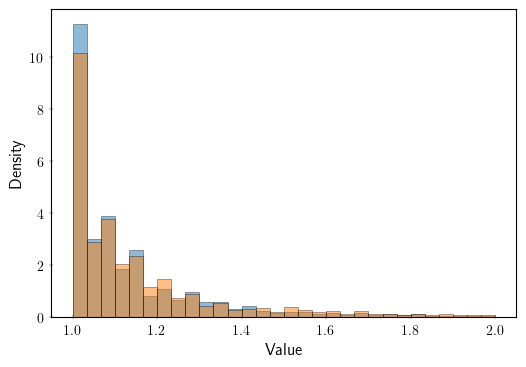

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(score_df['0'], bins=30, density=True, alpha=0.5, range=(1, 2), edgecolor='black', linewidth=0.5)
ax.hist(score_df['1'], bins=30, density=True, alpha=0.5, range=(1, 2), edgecolor='black', linewidth=0.5)
ax.set_xlabel("Value")
ax.set_ylabel("Density")
plt.savefig(data_path.parent / 'presentation' / 'figures' / 'distribution_comparison.pdf', bbox_inches='tight')

plt.show()

In [41]:
def fit_alpha(all_data, x_min):
    data = all_data[all_data >= x_min]

    n = len(data)
    sum_log = np.sum(np.log(data / x_min))
    alpha = 1 + n / sum_log
    return alpha, (alpha - 1) * x_min ** (alpha - 1)


def get_area(bin_start, bin_end, alpha, C):
    return C * (bin_end ** (1 - alpha) - bin_start ** (1 - alpha)) / (1 - alpha)

def get_samps_exceed(alpha, x_min, threshold):
    return (threshold / x_min) ** (alpha-1)

In [42]:
data = tet_30_scores
data = data[data > 0]

x_min = data.min()
sub_data = data[data >= x_min]

alpha, C = fit_alpha(sub_data, x_min)
C = C * len(sub_data) / len(data)

min_val = np.min(data)
max_val = np.max(data)
log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=20)

counts, bin_edges = np.histogram(data, bins=log_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1:] - bin_edges[:-1]
counts = counts / (len(data) * bin_width)

non_zero_indices = counts > 0
x_values = bin_centers[non_zero_indices]
y_values = counts[non_zero_indices]

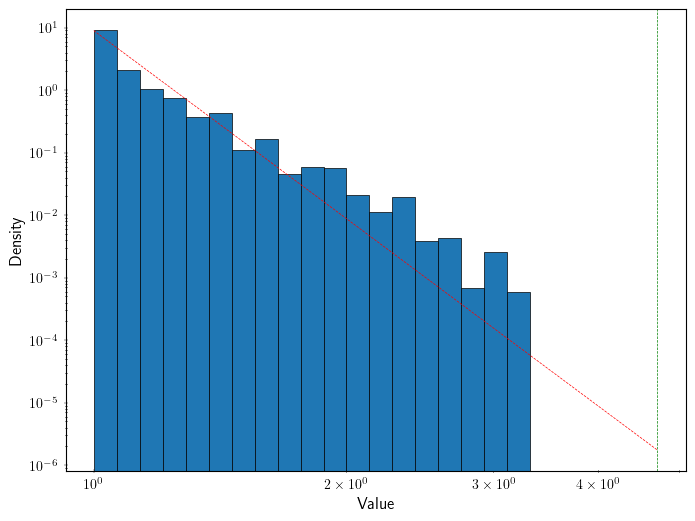

Samples exceeding 3,301,592


In [48]:
reached_score = 4.714285714285714

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(np.sort(np.r_[data, reached_score]), C * np.sort(np.r_[data, reached_score]) ** (-alpha), color="r", ls="--")

true_area = 0

for i in range(len(counts)):
    bin_start = bin_edges[i]
    bin_end = bin_edges[i + 1]
    bin_height = counts[i]

    # bin_height_true = get_area(bin_start, bin_end, alpha, C) / (bin_end - bin_start)

    rect = patches.Rectangle(
        (bin_start, 0),
        bin_end - bin_start,
        bin_height,
        linewidth=0.5,
        edgecolor="black",
        facecolor="C0",
    )
    # rect_true = patches.Rectangle((bin_start, 0), bin_end - bin_start, bin_height_true, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    # ax.add_patch(rect_true)
# ax.scatter(bin_centers, counts, color='blue', label='Binned Data', s=10)


scale = 1.1
x_min = np.max(bin_edges) * (1 - scale) / 2 + np.min(bin_edges) * (1 + scale) / 2
x_max = np.max(bin_edges) * (1 + scale) / 2 + np.min(bin_edges) * (1 - scale) / 2
y_min = np.max(counts) * (1 - scale) / 2
y_max = np.max(counts) * (1 + scale) / 2


# ax.set_xlim(x_min, x_max)
# ax.set_ylim(0, y_max)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Value")
plt.ylabel("Density")
# plt.savefig(mcmc_result_path / "tet_30_scores_histogram.pdf", bbox_inches="tight")
plt.axvline(reached_score, color="green", ls="--")
plt.savefig(data_path.parent / 'presentation' / 'figures' / 'sim_annealing_hist.pdf', bbox_inches="tight")
# plt.grid()
plt.show()

print(f"Samples exceeding {get_samps_exceed(alpha, x_min, reached_score):,.0f}")

In [54]:
df = pd.read_csv(mcmc_result_path / f"agg_score_alex_det_chains.csv", index_col=0)

rhats = []
sizes = []

for i in range(100, len(df), 100):
    rhat, ess = compute_rhat(df.iloc[:i])
    rhats.append(rhat)
    sizes.append(i)

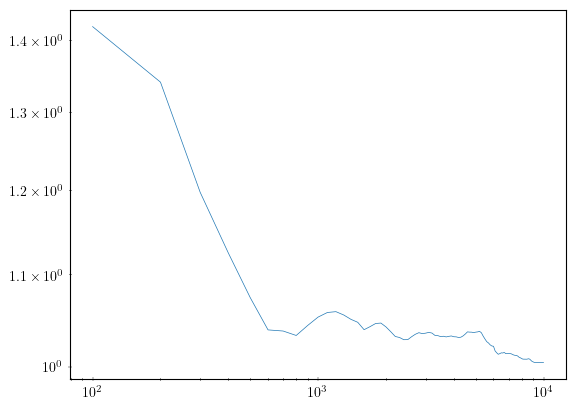

In [56]:
plt.plot(sizes, rhats)
plt.yscale("log")
plt.xscale("log")
